* Data cleaning
* word2vec
* Batch updates
* No MTL
* Regularization
* No weighting

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import itertools
from collections import defaultdict, OrderedDict
from random import shuffle
from tqdm import tqdm_notebook as tqdm, tnrange as trange
from sklearn.metrics import confusion_matrix

import sys
sys.path.insert(0, '..')
from evalResult import get_predicted, get_observed
plt.style.use('seaborn')

In [2]:
dataset = 'FR'

## Hyperparameters
Here for easy tuning.

In [3]:
# optimal 1e-4
lr = 1e-4
batch_size = 32
n_epochs = 20
ld = 1e-3

## Data

### Cleaning
Prepare words for cleaning. Specifically, find
1. ~~stopwords~~
1. punctuation
1. hashtags
1. @ mentions
1. numbers
1. URLs

In [4]:
re_punc = r'^[^a-zA-Z0-9]+$'
re_hash = r'^#'
re_at = r'^@'
re_num = r'\d'  # just remove all words with numbers
re_url = r'(^http:|\.com$)'

In [5]:
def clean_word(w):
    w = w.strip()
    if re.match(re_punc, w):
        return '#PUNC#'
    if re.match(re_hash, w):
        return '#HASH#'
    if re.match(re_at, w):
        return '#AT#'
    if re.match(re_num, w):
        return '#NUM#'
    if re.match(re_url, w):
        return '#URL#'
    return w.lower()

### I/O

In [6]:
def parse(train_filename):
    with open(train_filename, 'r') as f:
        lines = f.readlines()

    observations, states = defaultdict(int), defaultdict(int)
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            obs, state = data_split
            observations[clean_word(obs)] += 1
            states[state] += 1
    return observations, states

In [7]:
def read_file(filename, clean=True):
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    sentence, label = [], []
    sentences, labels = [], []
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            word, state = data_split
            if clean:
                word = clean_word(word)
            sentence.append(word)
            label.append(state)
        else:
            sentences.append(sentence)
            labels.append(label)
            sentence = []
            label = []
    return sentences, labels

### Train data

In [8]:
train_filename = f'../data/{dataset}/train'

observations, states = parse(train_filename)

In [9]:
train_sentences, train_labels = read_file(train_filename)
train_sentences[0][:5], train_labels[0][:5]

(['nous', 'avons', 'tout', 'aimé', '#PUNC#'], ['O', 'O', 'O', 'O', 'O'])

### Validation data

In [10]:
val_filename = f'../data/{dataset}/dev.out'
val_sentences, val_labels = read_file(val_filename)
val_sentences[0][:5], val_labels[0][:5]

(['petite', 'salle', 'ambiance', 'plage', 'oléronaise'],
 ['O', 'O', 'B-neutral', 'O', 'O'])

In [11]:
out_filename = f'../data/{dataset}/dev.p5.out'

## Encoding

In [12]:
def one_hot_encode(n, depth):
    a = np.zeros([depth, 1])
    a[n, 0] = 1
    return a

### Encode words
Create a vocabulary out of words that appear more than `1` time(s) in training. Each word now maps to an _integer_. Other words will be treated as `#UNK#`.

In [13]:
w2v_W = np.load(f'weights/word2vec/{dataset}/W.npy')
w2v_U = np.load(f'weights/word2vec/{dataset}/U.npy')

def word2vec(sentence):
    """
    sentence: array of one-hot vectors [n_words, n_tokens]
    """
    weights = 0.5 * (w2v_W + w2v_U.T)  # [300, n_tokens]
    return sentence.dot(weights.T)  # [n_words, 300]

In [14]:
def tokenize(token_mapping, sentence):
    """
    Function to convert each word into its corresponding integer
    If word is not found, return the value for '#UNK'
    """
    return [token_mapping.get(w, token_mapping['#UNK#']) for w in sentence]



def prepare_inputs(token_mapping, sentences):
    """
    Converts a 2-D list of sentences (list of list of words)
    to one-hot encoded tokens of shape [n_sentences, n_words, len(token_mapping), 1].
    """
    tokens = [tokenize(token_mapping, sentence) for sentence in sentences] 
    
    depth = len(token_mapping)
    one_hot_tokens = []
    for sentence in tokens:
        one_hot_sentence = []
        for i, token in enumerate(sentence):
            if token != token_mapping['#UNK#']:
                one_hot_sentence.append(one_hot_encode(token, depth))
            else:
                if i <= 2:
                    context_tokens = sentence[:i] + sentence[i+1:i+3]
                else:
                    context_tokens = sentence[i-2:i] + sentence[i+1:i+3]
                context_one_hot = [one_hot_encode(token, depth) for token in context_tokens]
                context_mean = np.mean(np.asarray(context_one_hot), axis=0)
                one_hot_sentence.append(context_mean)
        one_hot_tokens.append(one_hot_sentence)
    
    # squeeze to convert from [len(sentence), n_tokens, 1] to [len(sentence), n_tokens]
    one_hot_tokens = [np.squeeze(np.asarray(ls), axis=2) for ls in one_hot_tokens]
    vec_tokens = [word2vec(sentence) for sentence in tqdm(one_hot_tokens)]
    vec_tokens = [np.expand_dims(sentence, axis=-1) for sentence in vec_tokens]  # add dimension back
    return vec_tokens
    # one_hot_tokens = [[one_hot_encode(token, depth) for token in sentence] for sentence in tokens]
    # one_hot_tokens = [np.asarray(ls) for ls in one_hot_tokens]  # list of [n_words, len(token_mapping), 1]
    # return one_hot_tokens

In [15]:
min_freq = 0

token_mapping = {}
for word in observations:
    if observations[word] > min_freq:  # appears more than once in training
        token_mapping[word] = len(token_mapping)
token_mapping['#UNK#'] = len(token_mapping)
len(token_mapping)

3843

In [16]:
X_train = prepare_inputs(token_mapping, train_sentences)
len(X_train), X_train[0].shape

(1632, (5, 300, 1))

### Encode labels
Perform a similar encoding for the states:
1. Map to integer
1. Convert from integer to one-hot-encoding

In [17]:
def prepare_labels(state_mapping, sequences):
    """
    Convert each state from str to its corresponding int value.
    Convert the int to a one-hot vector.
    """
    encoded_labels = [[state_mapping[state] for state in label] for label in sequences]
    
    depth = len(state_mapping)
    one_hot_labels = [[one_hot_encode(label, depth) for label in sequence] for sequence in encoded_labels]
    one_hot_labels = [np.asarray(ls) for ls in one_hot_labels]
    return one_hot_labels

In [18]:
state_mapping = {state: i for i, state in enumerate(states)}
state_mapping

{'O': 0,
 'B-positive': 1,
 'I-positive': 2,
 'B-negative': 3,
 'B-neutral': 4,
 'I-negative': 5,
 'I-neutral': 6}

In [19]:
y_train = prepare_labels(state_mapping, train_labels)
len(y_train), y_train[0].shape

(1632, (5, 7, 1))

### Validation
Perform a similar encoding for validation data, based on the states and tokens of the training data.

In [20]:
X_val = prepare_inputs(token_mapping, val_sentences)
y_val = prepare_labels(state_mapping, val_labels)

In [21]:
X_flat = []
for sentence in X_train:
    X_flat.extend(sentence)
X_flat = np.asarray(X_flat)
X_flat = np.squeeze(X_flat, axis=-1)
X_flat.shape

(26567, 300)

In [22]:
y_flat = []
for sentence in y_train:
    y_flat.extend(sentence)
y_flat = np.asarray(y_flat)
y_flat = np.squeeze(y_flat, axis=-1)
y_flat.shape

(26567, 7)

## Keras

In [23]:
from functools import reduce
from operator import add
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced',
                               classes=list(states),
                               y=reduce(add, ([k]*v for k, v in states.items())))
weights

array([ 0.15483378,  4.68553792, 20.96842936,  5.6226455 , 33.58659924,
       16.28877989, 88.26245847])

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [25]:
model = Sequential([
    Dense(128, input_dim=300, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(state_mapping), activation='softmax')
])

model.compile(loss='mean_squared_error',
              optimizer='adagrad',
              metrics=['accuracy'])

In [26]:
history = model.fit(X_flat, y_flat,
                    epochs=10,
                    batch_size=64,
                    class_weight=weights)

Epoch 1/10
26567/26567 [==============================] - 1s 45us/step - loss: 0.0173 - acc: 0.9243
Epoch 2/10
26567/26567 [==============================] - 1s 33us/step - loss: 0.0145 - acc: 0.9325
Epoch 3/10
26567/26567 [==============================] - 1s 36us/step - loss: 0.0139 - acc: 0.9343
Epoch 4/10
26567/26567 [==============================] - 1s 35us/step - loss: 0.0136 - acc: 0.9349
Epoch 5/10
26567/26567 [==============================] - 1s 35us/step - loss: 0.0134 - acc: 0.9359
Epoch 6/10
26567/26567 [==============================] - 1s 40us/step - loss: 0.0132 - acc: 0.9366
Epoch 7/10
26567/26567 [==============================] - 1s 31us/step - loss: 0.0131 - acc: 0.9370
Epoch 8/10
26567/26567 [==============================] - 1s 28us/step - loss: 0.0129 - acc: 0.9374
Epoch 9/10
26567/26567 [==============================] - 1s 36us/step - loss: 0.0128 - acc: 0.9377
Epoch 10/10
26567/26567 [==============================] - 1s 31us/step - loss: 0.0127 - acc: 0.9388

In [27]:
y_pred, y_true = [], []

for i in trange(len(X_val)):
    pred = model.predict(np.squeeze(X_val[i], axis=2))
    pred = np.argmax(pred, axis=1)
    y_pred.extend(pred)
    
    y_true.extend(np.argmax(y_val[i], axis=1).flatten())
    
y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)

In [28]:
np.mean(y_true == y_pred)

0.9232987312572087

Confusion matrix, without normalization


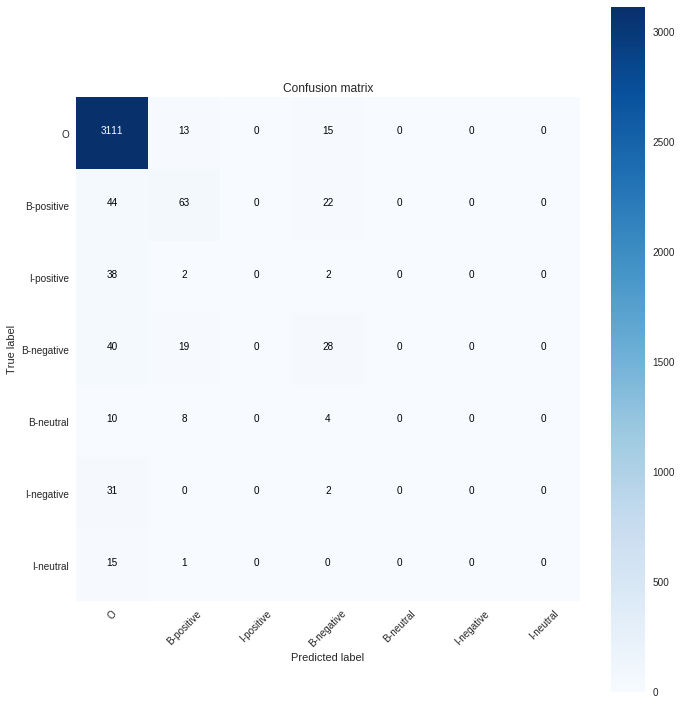

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
cm = confusion_matrix(y_true, y_pred)
classes = list(state_mapping)

plt.figure(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(cm, classes=classes)

## Prediction

In [30]:
def decode(seq):
    states = list(state_mapping)
    return [states[int(i)] for i in seq]

In [31]:
def write_predictions(X):
    # get and store predictions
    result = []
    for sentence in tqdm(X):
        pred = model.predict(np.squeeze(sentence, axis=2))
        pred = np.argmax(pred, axis=1)
        result.append(decode(pred))
    # write predictions to file
    with open(out_filename, 'w') as f:
        for i in range(len(val_sentences)):
            for j in range(len(val_sentences[i])):
                word = val_sentences[i][j]
                pred = result[i][j]
                f.write(word + ' ' + pred + '\n')
            f.write('\n')

In [32]:
write_predictions(X_val)